In [133]:
# Doing all the imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
import numpy as np
import os

This is the prediction model that will return the best prediction model according to the data given to it

In [134]:
# Data is expected to be n*2 np array with the first column being the values and the second column being the years

def predictParameterModel(data):
    # print(data)
    last_data = data[-1,:]
    actual_param = last_data[0]
    data = data[:-1,:]
    values = data[:,0]
    year = data[:,1]
    degree_list = [1,2,3,4,5]

    min = 10000
    best_degree = 0
    for degree in degree_list:
        coefficients = np.polyfit(year, values, degree)
        poly_fit = np.poly1d(coefficients)
        predicted_param = poly_fit(int(last_data[1]))
        loss = abs(predicted_param-actual_param)
        if loss < min:
            min = loss
            best_degree = degree

    coefficients = np.polyfit(year, values, best_degree)
    poly_fit = np.poly1d(coefficients)

    return poly_fit

In [135]:
# Getting the data

DATA = 'full_data.csv'
data = pd.read_csv(DATA, encoding="ISO-8859-1")
data['STATE'] = data['STATE'].str.upper() # to capitalize all the states
print(data.shape)
no_of_rows = data.shape[0]

(14606, 12)


In [136]:
nan_indices = data[data['STATE'] == 'NAN'].index.tolist()
data = data.drop(nan_indices)
STATE_NAME_LIST = sorted(data['STATE'].unique())
YEAR_LIST = [2022, 2023, 2024, 2025, 2026]

In [137]:
# Data pre-processing

data.fillna(0, inplace=True)
# print(data.dtypes)

data['Temp'] = pd.to_numeric(data['Temp'], errors = 'coerce')
data['D.O. (mg/l)'] = pd.to_numeric(data['D.O. (mg/l)'], errors = 'coerce')
data['PH'] = pd.to_numeric(data['PH'], errors='coerce')
data['B.O.D. (mg/l)'] = pd.to_numeric(data['B.O.D. (mg/l)'], errors='coerce')
data['CONDUCTIVITY'] = pd.to_numeric(data['CONDUCTIVITY'], errors='coerce')
data['NITRATENAN N+ NITRITENANN (mg/l)'] = pd.to_numeric(data['NITRATENAN N+ NITRITENANN (mg/l)'], errors='coerce')
data['TOTAL COLIFORM (MPN/100ml)Mean'] = pd.to_numeric(data['TOTAL COLIFORM (MPN/100ml)Mean'], errors='coerce')

start = 0
end = no_of_rows

station = data.iloc[start:end, 0]
location = data.iloc[start:end ,1]
state = data.iloc[start:end, 2]
do = data.iloc[start:end, 4].astype(np.float64)
ph = data.iloc[start:end, 5]  
co = data.iloc [start:end, 6].astype(np.float64)   
year = data.iloc[start:end, 11]
tc = data.iloc[start:end, 10].astype(np.float64)
bod = data.iloc[start:end, 7].astype(np.float64)
na = data.iloc[start:end, 8].astype(np.float64)

# print(data.columns)
data = pd.concat([station,location,state,do,ph,co,bod,na,tc,year], axis=1)
# print(data.columns)
data.columns = ['station','location','state','do','ph','co','bod','na','tc','year']

In [138]:
# Adding more columns/features to the data using the already given features

#calulation of Ph
data['npH']=data.ph.apply(lambda x: (100 if (8.5>=x>=7)  
                                 else(80 if  (8.6>=x>=8.5) or (6.9>=x>=6.8) 
                                      else(60 if (8.8>=x>=8.6) or (6.8>=x>=6.7) 
                                          else(40 if (9>=x>=8.8) or (6.7>=x>=6.5)
                                              else 0)))))
#calculation of dissolved oxygen
data['ndo']=data.do.apply(lambda x:(100 if (x>=6)  
                                 else(80 if  (6>=x>=5.1) 
                                      else(60 if (5>=x>=4.1)
                                          else(40 if (4>=x>=3) 
                                              else 0)))))
#calculation of total coliform
data['nco']=data.tc.apply(lambda x:(100 if (5>=x>=0)  
                                 else(80 if  (50>=x>=5) 
                                      else(60 if (500>=x>=50)
                                          else(40 if (10000>=x>=500) 
                                              else 0)))))
#calc of B.D.O
data['nbdo']=data.bod.apply(lambda x:(100 if (3>=x>=0)  
                                 else(80 if  (6>=x>=3) 
                                      else(60 if (80>=x>=6)
                                          else(40 if (125>=x>=80) 
                                              else 0)))))
#calculation of electrical conductivity
data['nec']=data.co.apply(lambda x:(100 if (75>=x>=0)  
                                 else(80 if  (150>=x>=75) 
                                      else(60 if (225>=x>=150)
                                          else(40 if (300>=x>=225) 
                                              else 0)))))
#Calulation of nitrate
data['nna']=data.na.apply(lambda x:(100 if (20>=x>=0)  
                                 else(80 if  (50>=x>=20) 
                                      else(60 if (100>=x>=50)
                                          else(40 if (200>=x>=100) 
                                              else 0)))))

data.dtypes
data['wph']=data.npH * 0.165
data['wdo']=data.ndo * 0.281
data['wbdo']=data.nbdo * 0.234
data['wec']=data.nec* 0.009
data['wna']=data.nna * 0.028
data['wco']=data.nco * 0.281
data['wqi']=data.wph+data.wdo+data.wbdo+data.wec+data.wna+data.wco 

In [139]:
data.columns

Index(['station', 'location', 'state', 'do', 'ph', 'co', 'bod', 'na', 'tc',
       'year', 'npH', 'ndo', 'nco', 'nbdo', 'nec', 'nna', 'wph', 'wdo', 'wbdo',
       'wec', 'wna', 'wco', 'wqi'],
      dtype='object')

In [140]:
# Convert columns to numeric
numeric_cols = ['year', 'do', 'ph', 'co', 'bod', 'na', 'tc', 'npH',	'ndo',	'nco','nbdo', 'nec', 'nna', 'wph', 'wdo', 'wbdo', 'wec', 'wna', 'wco', 'wqi']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [141]:
parameter_list = ['do', 'ph', 'co', 'bod', 'na', 'tc', 'npH', 'ndo', 'nco','nbdo', 'nec', 'nna', 'wph', 'wdo', 'wbdo', 'wec', 'wna', 'wco', 'wqi']
predictions = {}
year_each_state = {}

In [142]:
# Predicting the WQI for each state

for state_name in STATE_NAME_LIST:
    if state_name == 'DAMAN AND DIU' or state_name == 'DADRA AND NAGAR HAVELI' or state_name == 'INTER-STATE':
        continue
    wqi_prediction = []
    aggregated_data = data[data['state'] == state_name][numeric_cols].groupby('year').mean()
    ag = aggregated_data
    old_wqi = ag['wqi'].tolist()
    year_list = aggregated_data.index.tolist()
    year_each_state[state_name] = year_list
    if(len(year_list) == 1 or len(year_list) == 0):
        continue
    np_year_list = np.array(year_list)
    import warnings
    warnings.filterwarnings("ignore", category=np.RankWarning)
    models_for_params = {}
    for parameter in parameter_list:
        values = np.array(ag[parameter].tolist())
        combined_array = np.stack((values, np_year_list), axis=1)
        model = predictParameterModel(combined_array)
        models_for_params[parameter] = model
    predicted_values = {}
    for year in YEAR_LIST:
        for parameter in parameter_list:
            predicted_values[parameter] = models_for_params[parameter](year)
        wqi = predicted_values['wph']+predicted_values['wdo']+predicted_values['wbdo']+predicted_values['wec']+predicted_values['wna']+predicted_values['wco']
        wqi_prediction.append(abs(wqi))
    total_wqi = old_wqi + wqi_prediction
    predictions[state_name] = total_wqi

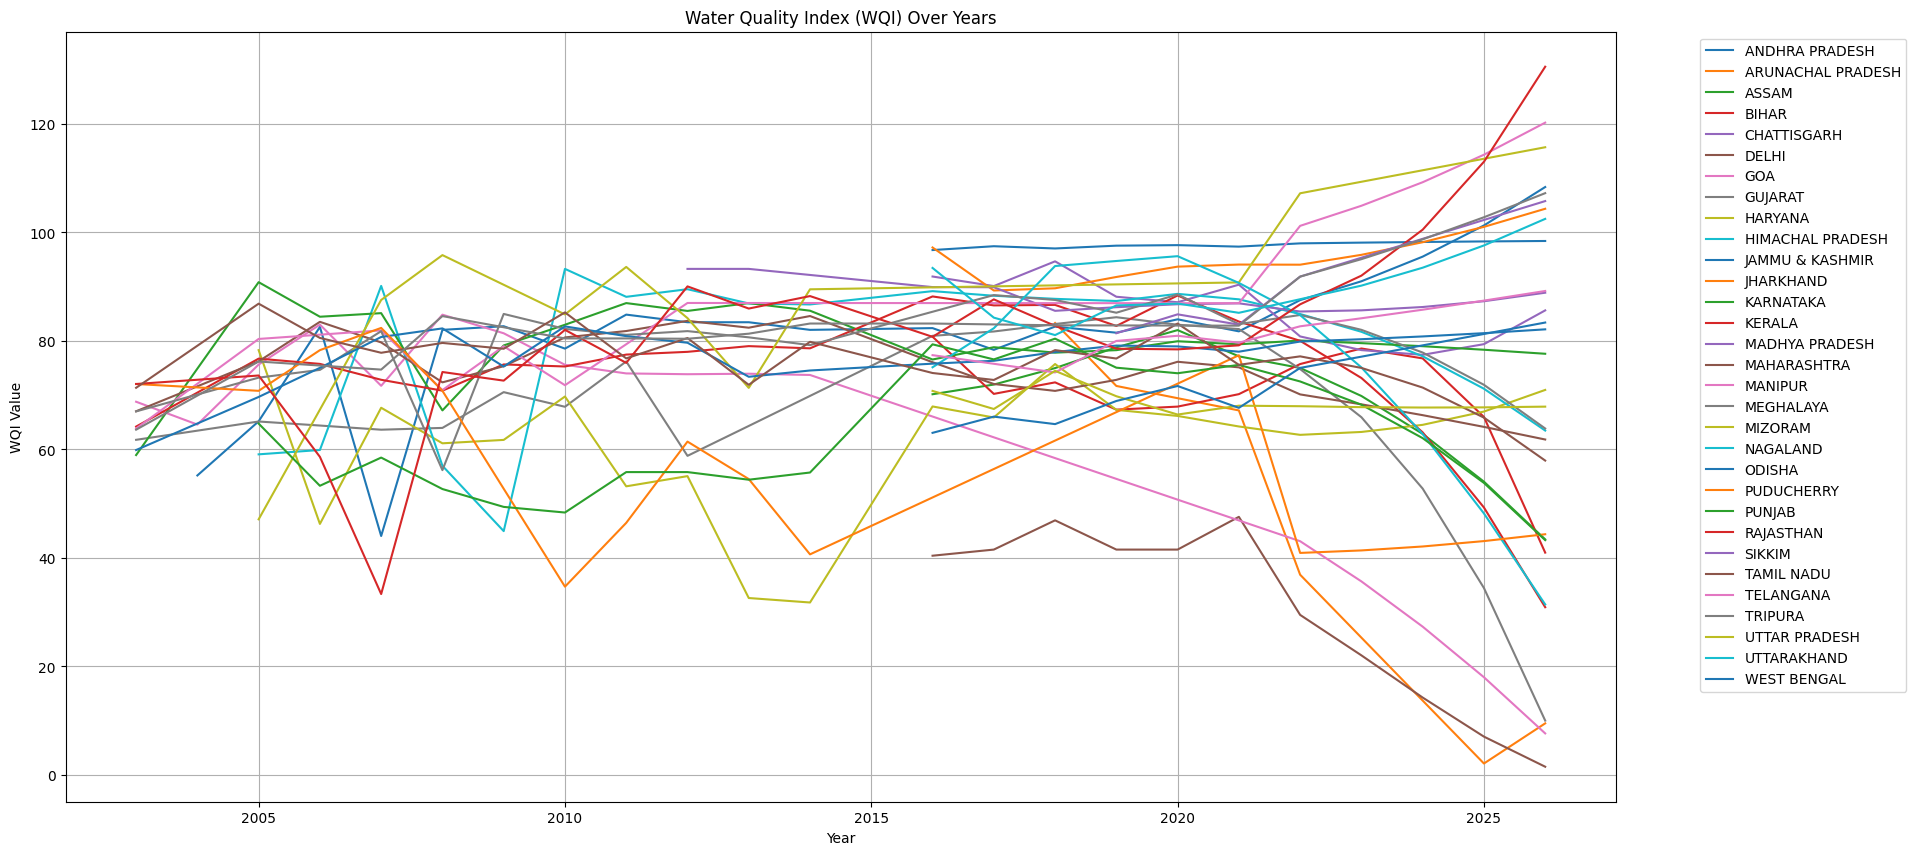

In [143]:
# Plotting the WQI for all the states in one plot
plt.figure(figsize=(20, 10))

for state, wqi_values in predictions.items():
    years = year_each_state[state] + YEAR_LIST
    plt.plot(years, wqi_values, label=state)

plt.title('Water Quality Index (WQI) Over Years')
plt.xlabel('Year')
plt.ylabel('WQI Value')

# Adjust the legend position
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the coordinates as needed

plt.grid(True)
plt.savefig(f'prediction_all_states.png', bbox_inches='tight')  # Adjust bbox_inches to prevent clipping
plt.show()

plt.close()


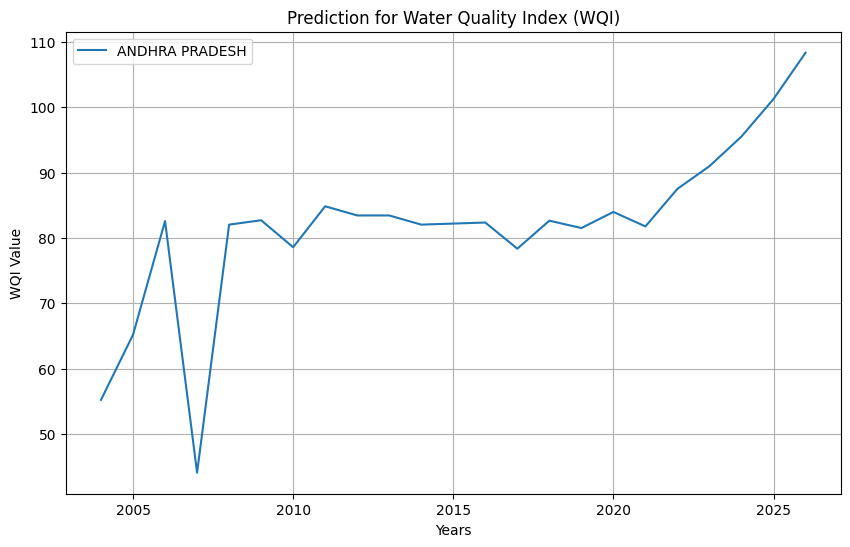

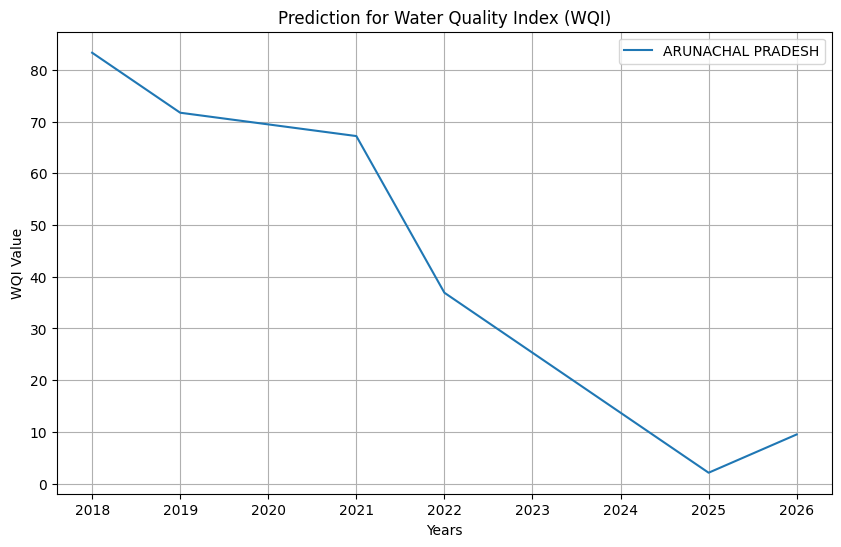

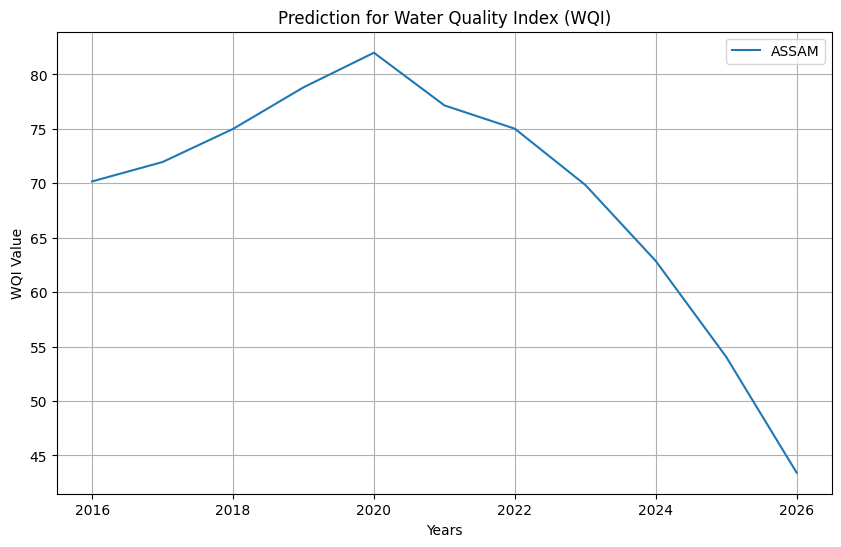

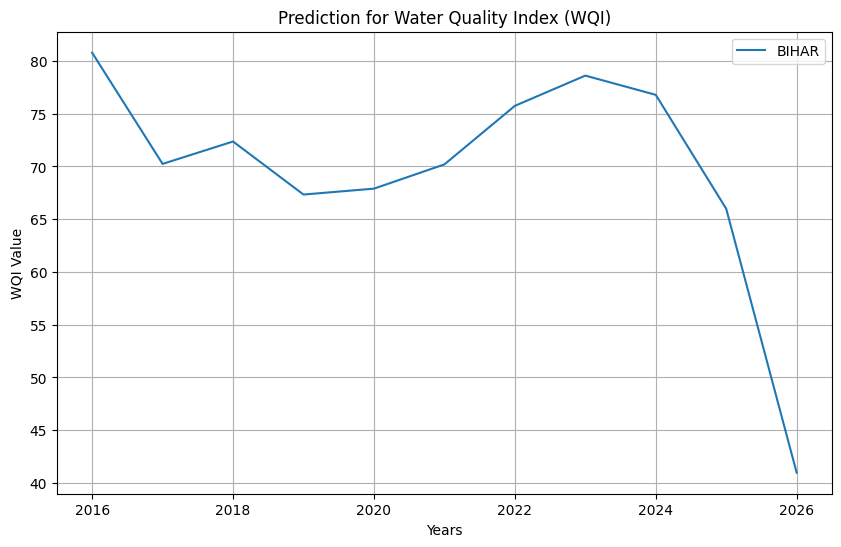

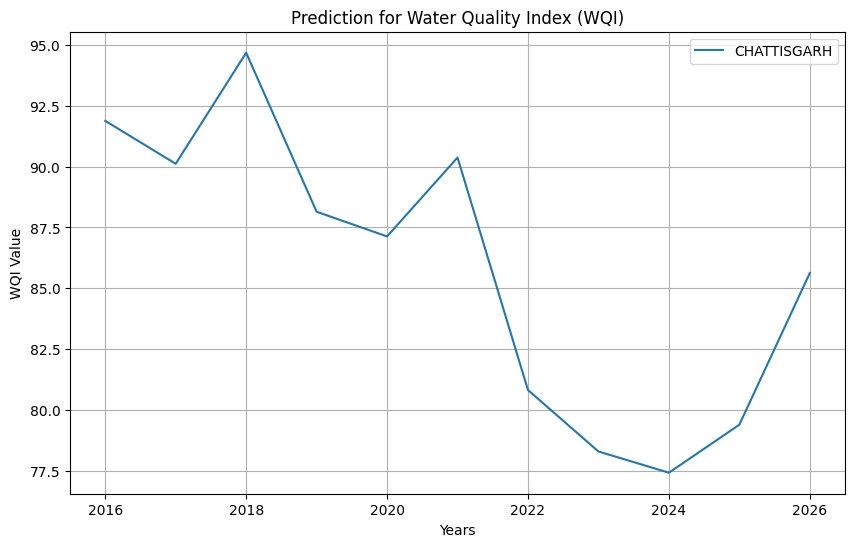

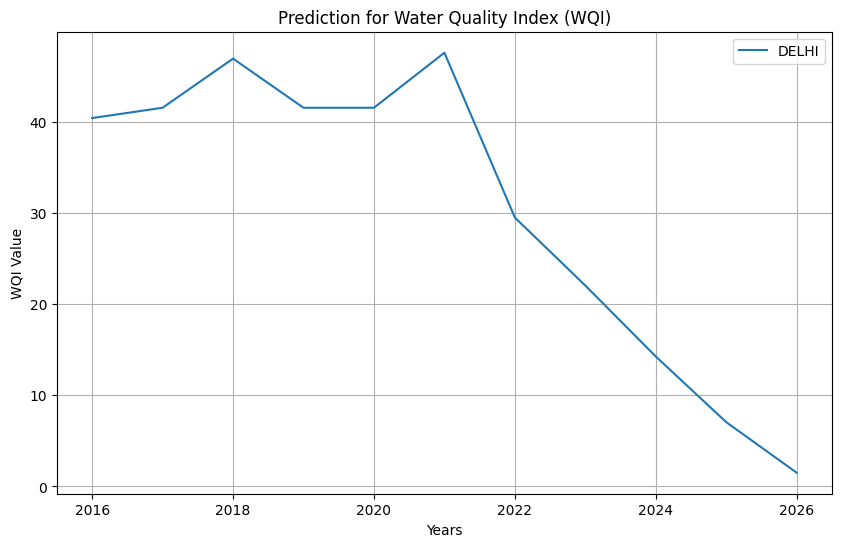

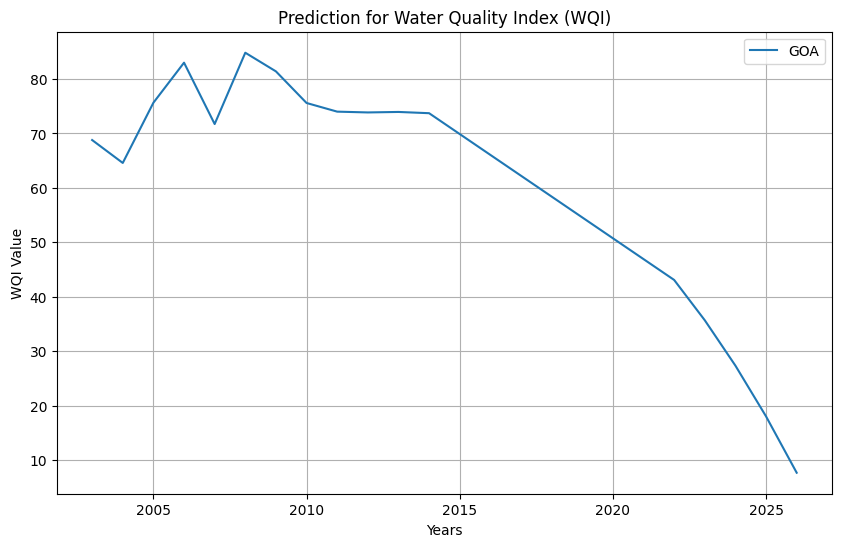

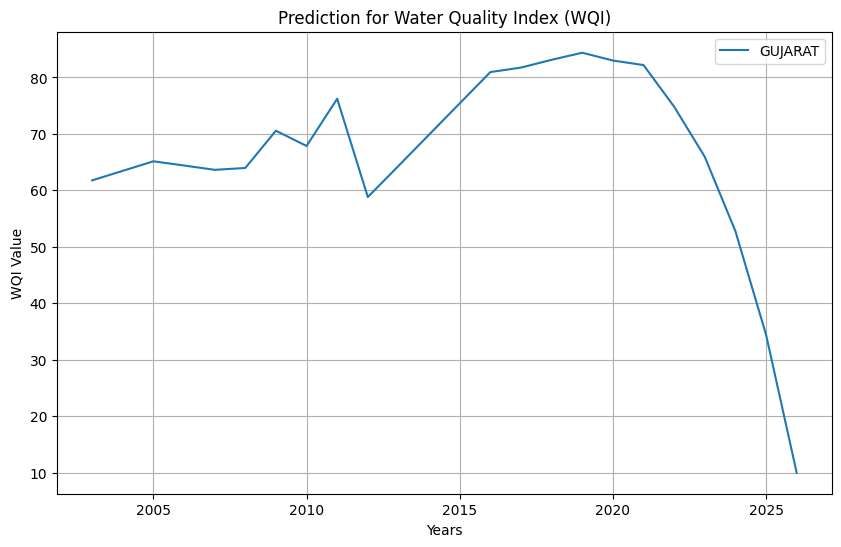

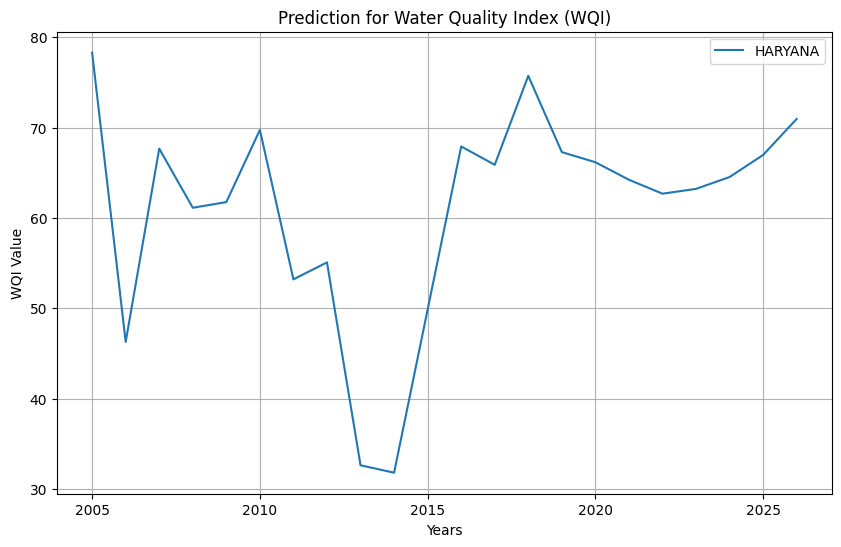

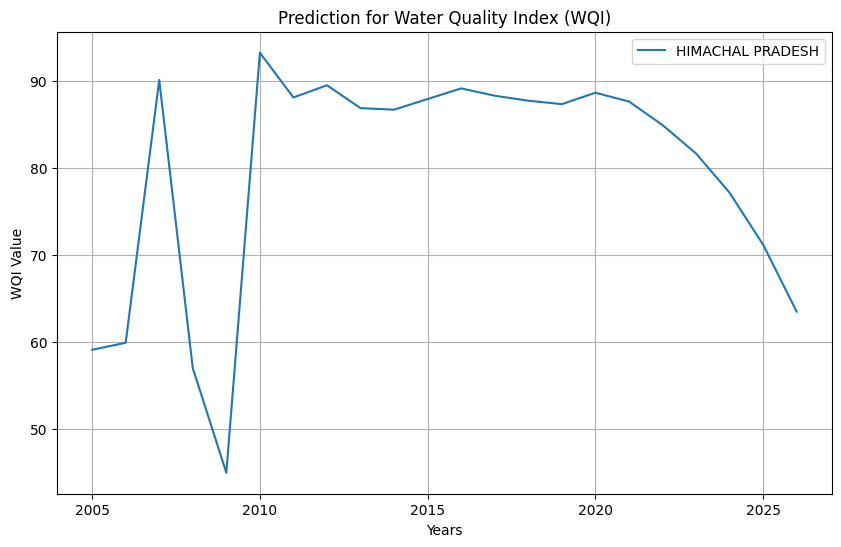

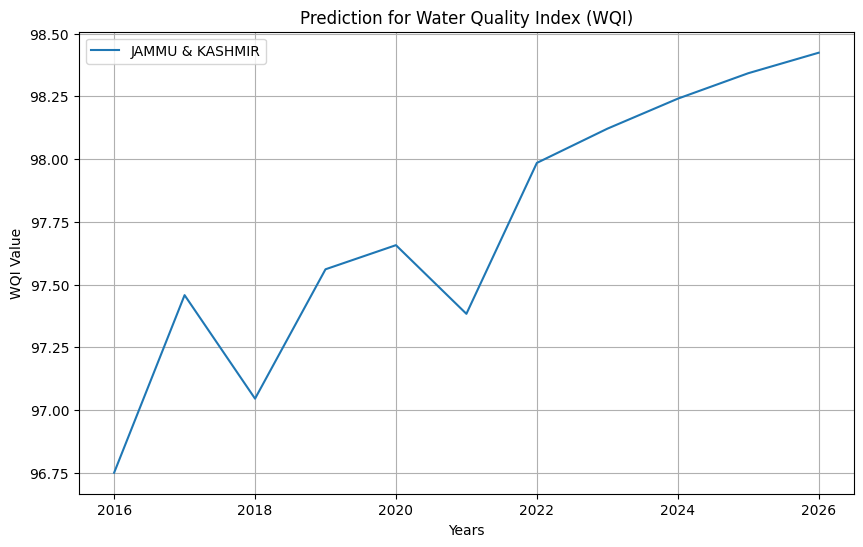

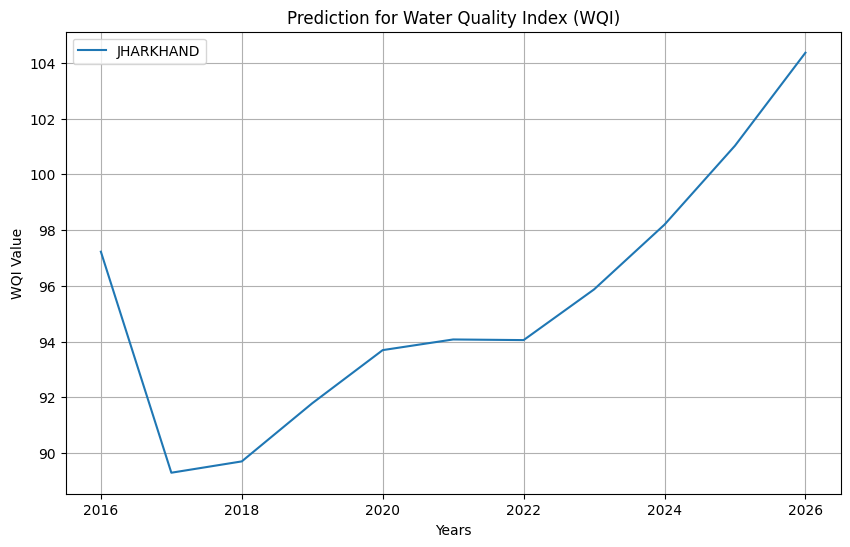

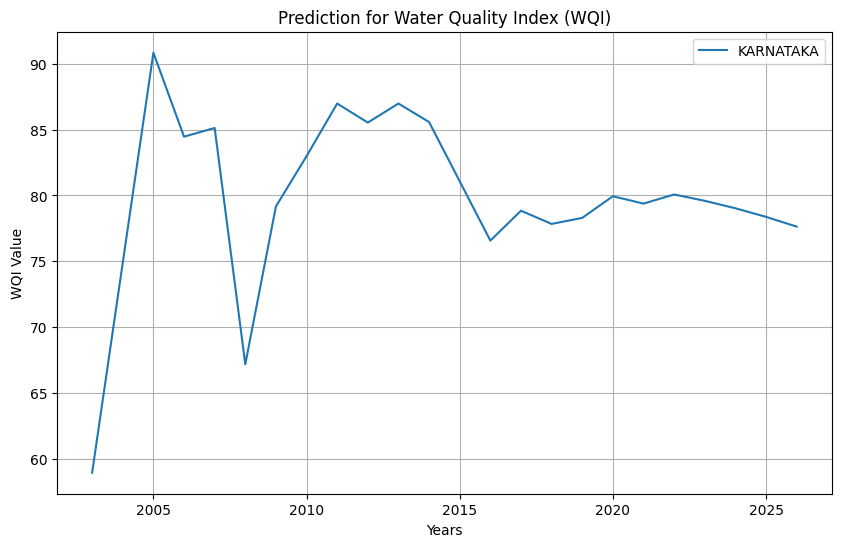

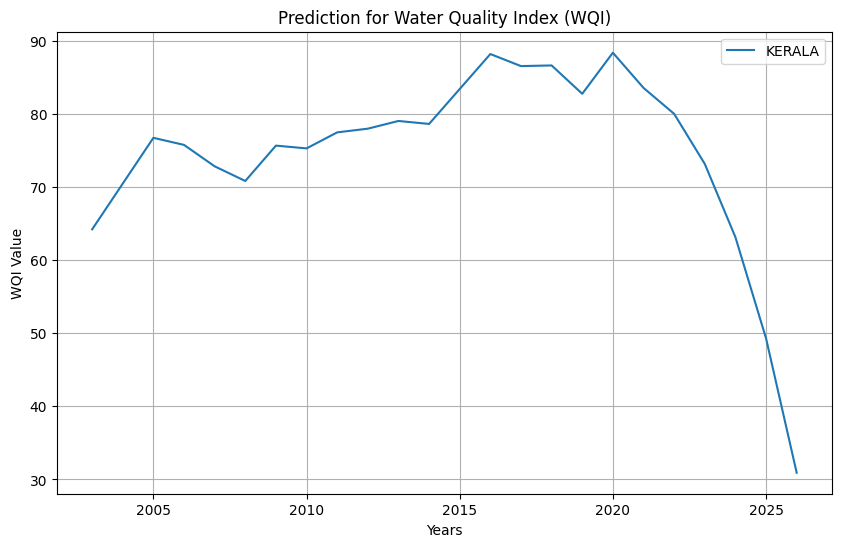

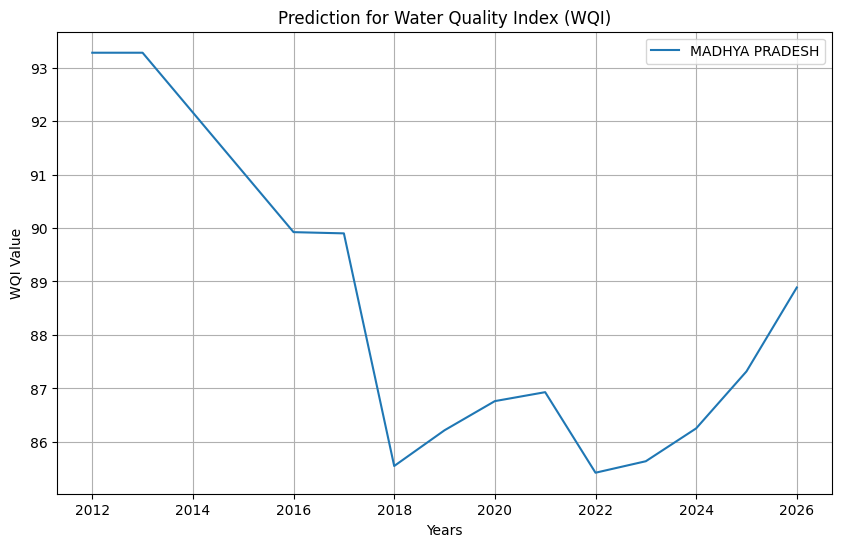

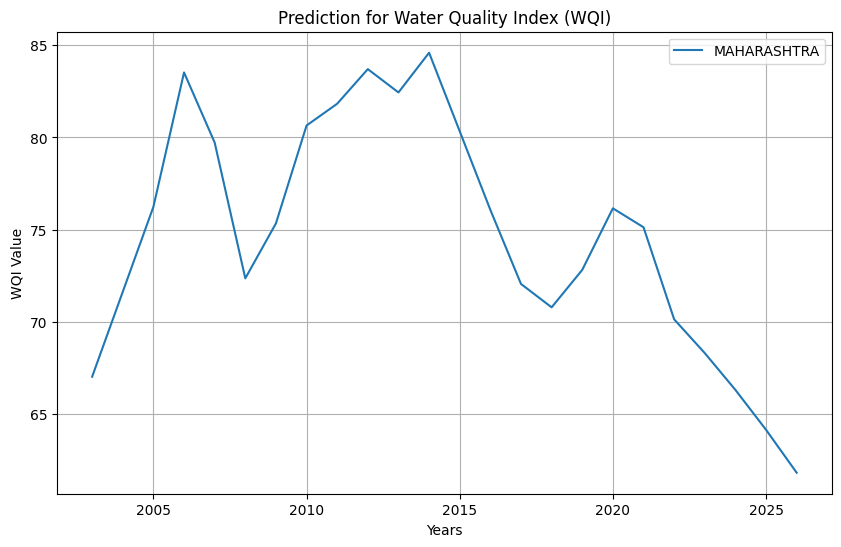

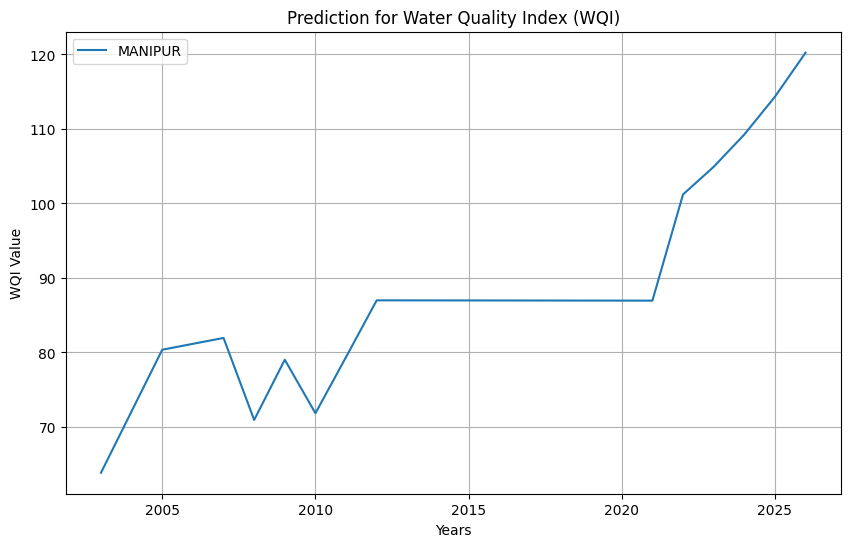

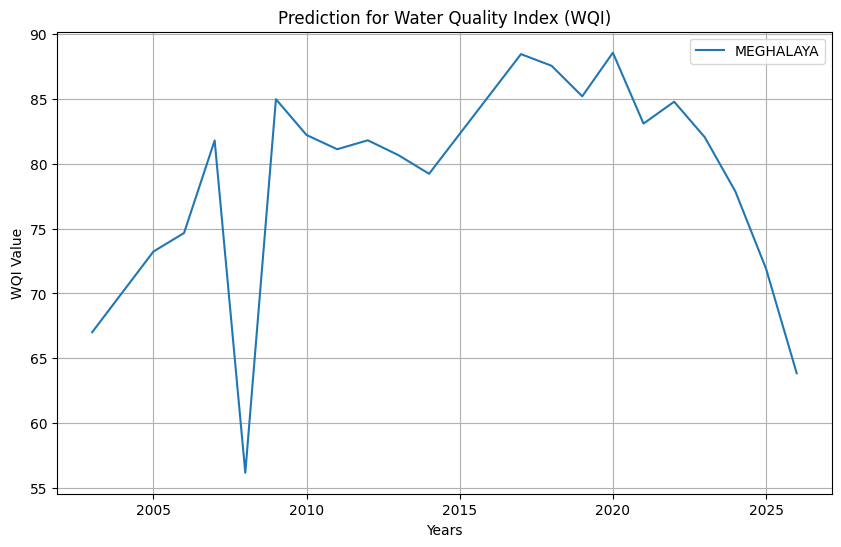

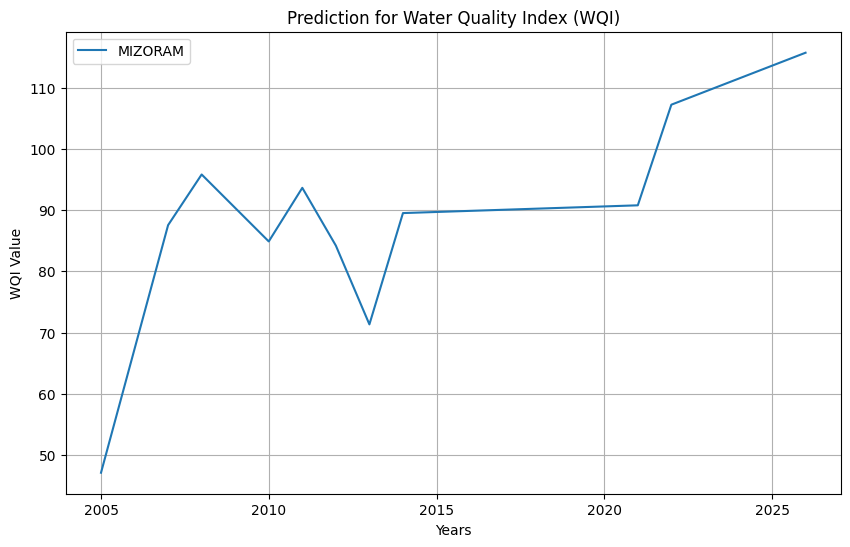

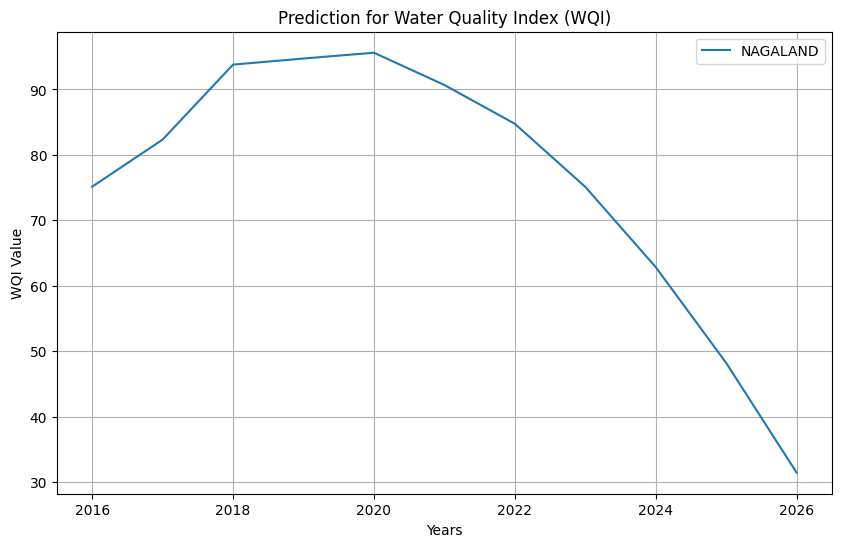

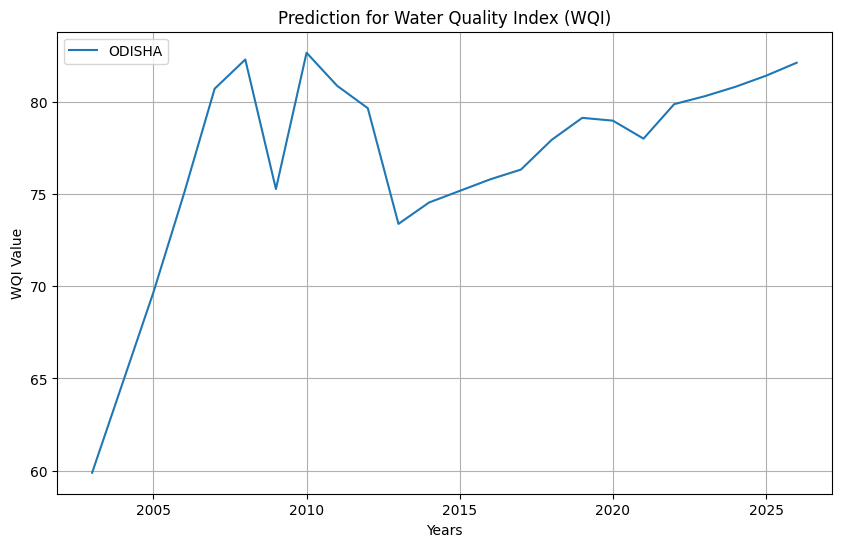

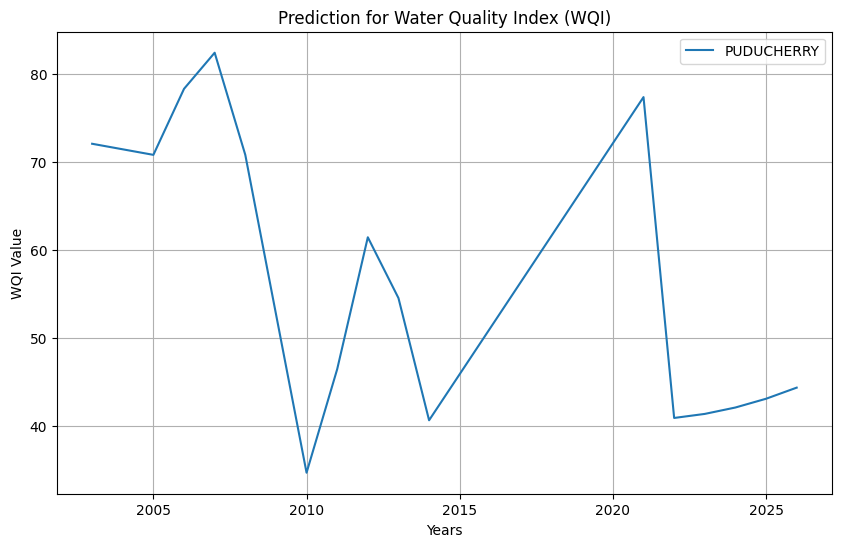

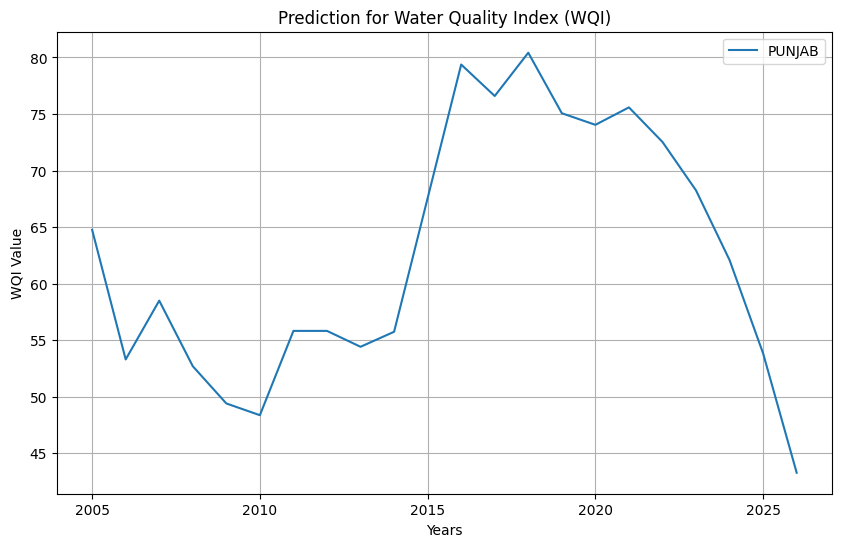

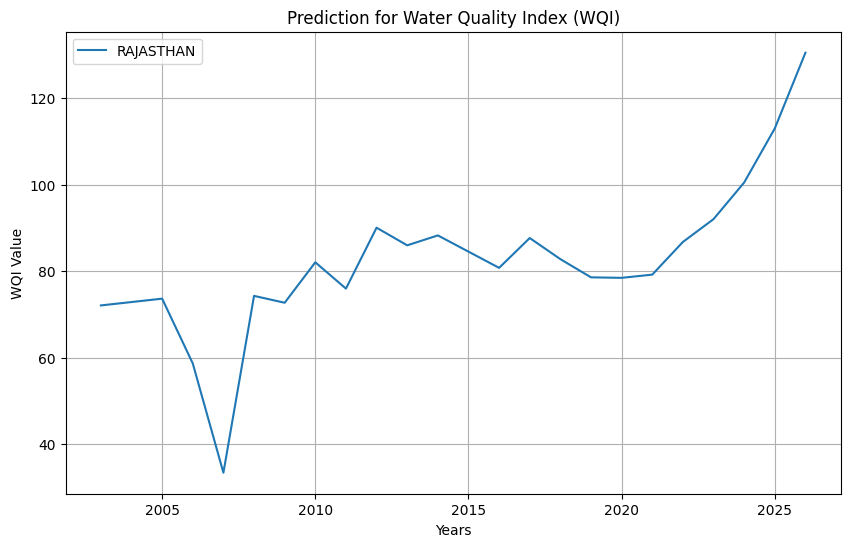

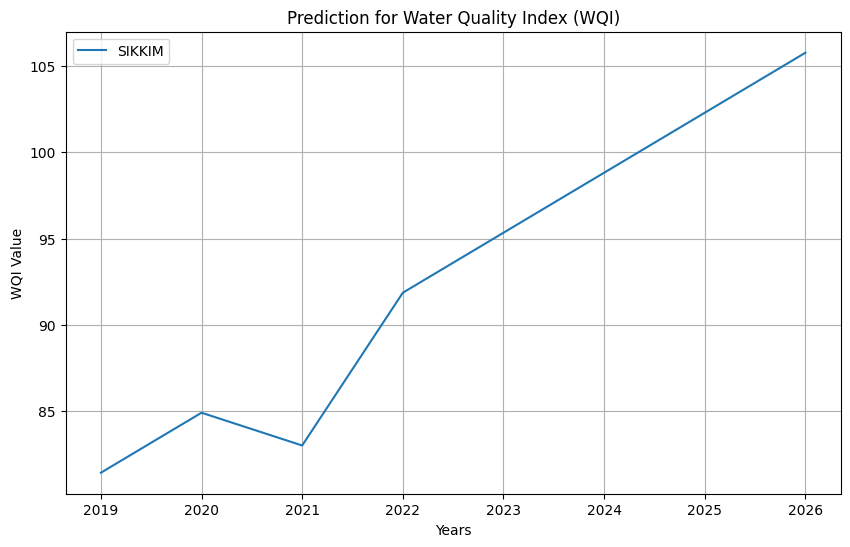

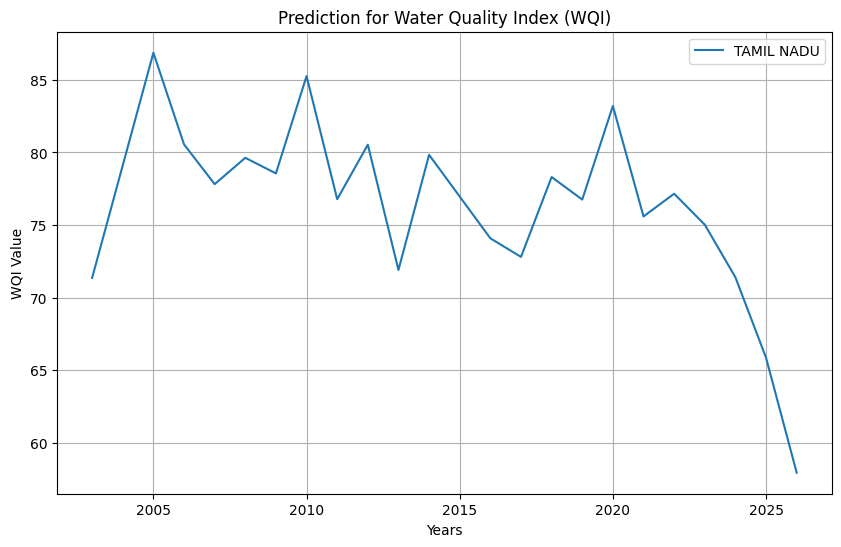

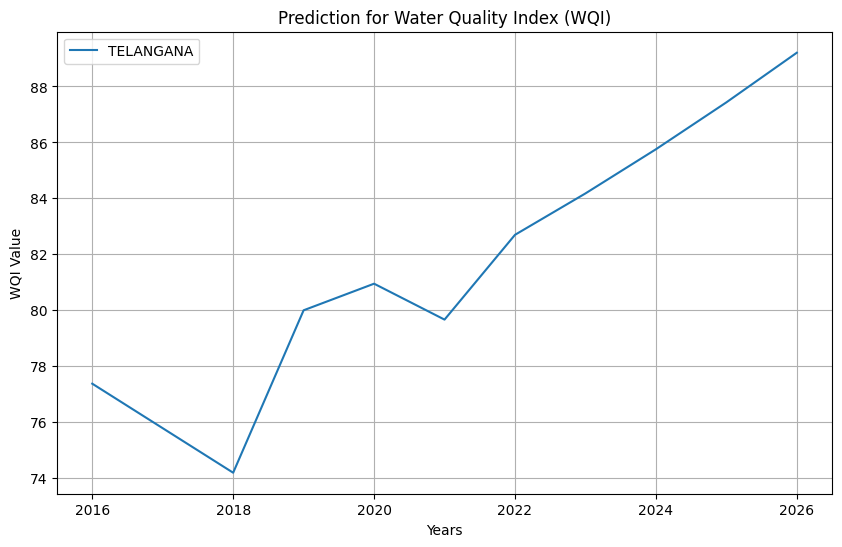

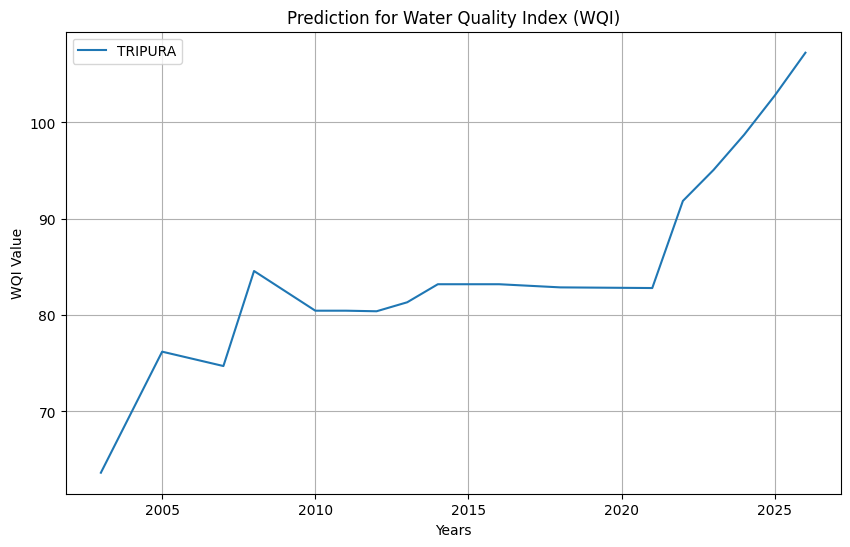

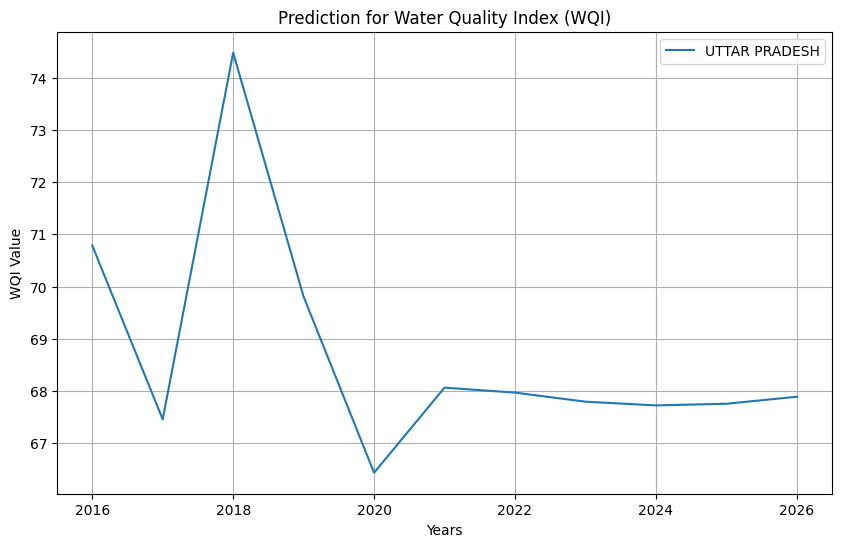

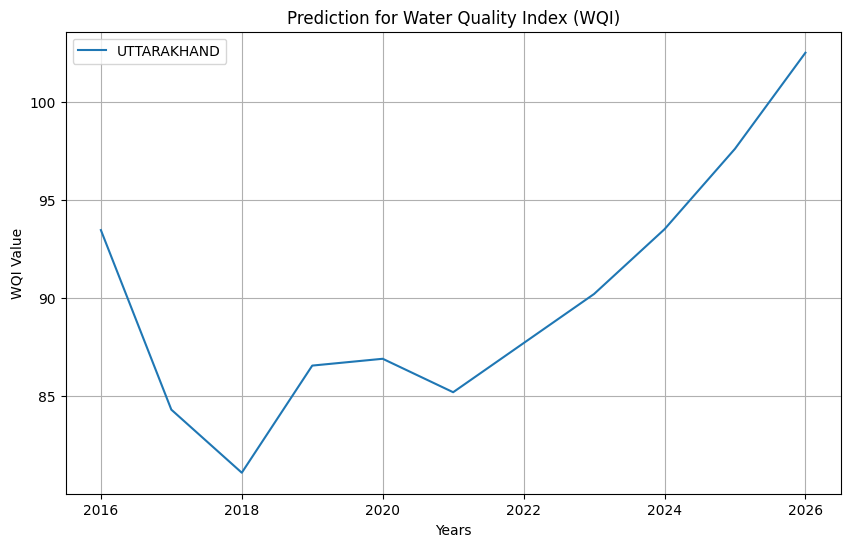

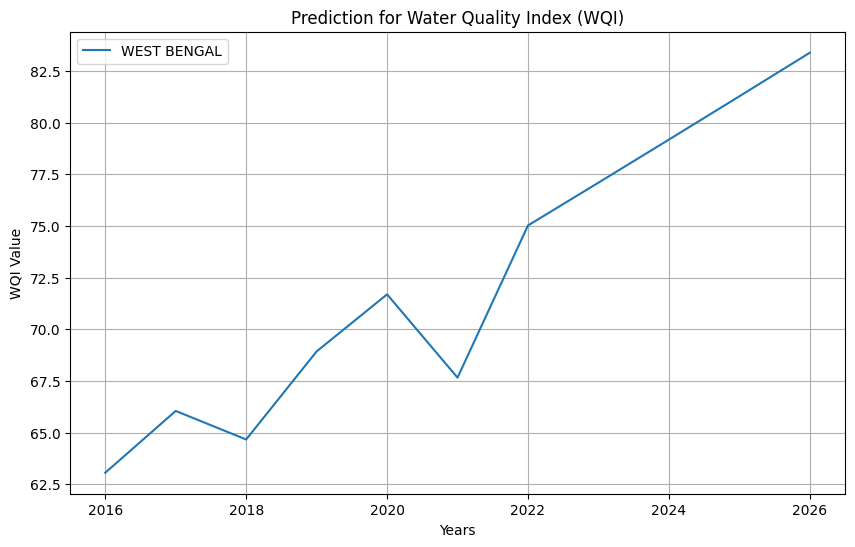

In [144]:
# Plotting wqi for each state

wqi_map = predictions

# Plotting

save_path = 'images/'

for state, wqi_values in wqi_map.items():
    wqi_values = wqi_map[state]
    plt.figure(figsize=(10, 6))
    plt.plot(year_each_state[state]+YEAR_LIST, wqi_values, label=state)
    plt.title('Prediction for Water Quality Index (WQI)')
    plt.xlabel('Years')
    plt.ylabel('WQI Value')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_path, f'{state}_WQI_Prediction.png'))
    plt.show()


    # Close the current figure to avoid overlapping plots in the next iteration
    plt.close()


